<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_09_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk.chat.util import Chat, reflections

What are *reflections*?

In [2]:
print(reflections)

{'i am': 'you are', 'i was': 'you were', 'i': 'you', "i'm": 'you are', "i'd": 'you would', "i've": 'you have', "i'll": 'you will', 'my': 'your', 'you are': 'I am', 'you were': 'I was', "you've": 'I have', "you'll": 'I will', 'your': 'my', 'yours': 'mine', 'you': 'me', 'me': 'you'}


We can add stuff.

In [3]:
reflections['myself'] = 'yourself'

We need to structure what will the bot respond to diverse prompts.

In [4]:
intro = ['Pleased to meet you, %1.', "Hello, %1, how's it going?",]
smalltalk = [ 'I am well, thanks', 'Okay',]
identify = ['I am a bot',]
positive = [ 'Nice', 'Excellent', 'Way to go', 'Good for you',]
negative = [ 'That sucks', 'Sorry to hear that', ':(',]
default = [ 'Wow', 'I hear you',]
questionResponse = [ # will be matched in this order
    [ r'my name is (.*)', intro ],
    [ r'I am (.*)', intro ],
    [ r'this is (.*)', intro ],
    [ r'who am I talking to|who is this', identify ],
    [ r"how are you|how about you|what's up", smalltalk ],
    [ r'not too bad|fine|well|great', positive ],
    [ r'bad|sucks', negative ],
    [ r'bonjour|hi|whazzup (.*)', ['ohai', 'Bonjour, ça va?',] ], 
    [ r'sorry (.*)', ['no biggie',] ],
    [ r'close|farewell (.*)', ['It was a pleasure', 'See you later',] ],
    [ r'(.*)\!', ['%1, for sure'] ],
    [ r'(.*)\?', ['whoah, %1!',] ],
    [ r'(.*)', default ]
]

Let's start a chat :)

In [21]:
print('At your service, mate.')
chat = Chat(questionResponse, reflections)
chat.converse(quit = 'close') # typing close will make it stop expecting more messages

At your service, mate.
>hi there
Bonjour, ça va?
>oh, you speak french
I hear you
>that is nice
I hear you
>who is this?
I am a bot
>my name is Elisa
Pleased to meet you, elisa.
>bye now
Wow
>sabes qué es eso?
whoah, sabes qué es eso!
>dude!
Wow
>close
It was a pleasure


So that is a *rule-based* chat bot. Another approach is to use machine learning and figure out based on training data what are appropriate responses for the bot. We will now start working towards that latter direction, following an [online Pykit tutorial](https://pykit.org/chatbot-in-python-using-nlp/).  The training data is a [JSON file](https://github.com/vishal-verma27/Building-a-Simple-Chatbot-in-Python-using-NLTK/blob/611bc5c96f25aa0e5f8e71a97c421fab7781214e/Train_Bot.json) that is similar to the rules above in the sense that it associates *patterns* to *responses*.

In [22]:
from urllib.request import urlopen
import json
url = 'https://raw.githubusercontent.com/vishal-verma27/Building-a-Simple-Chatbot-in-Python-using-NLTK/611bc5c96f25aa0e5f8e71a97c421fab7781214e/Train_Bot.json'
data = urlopen(url) 
intents = json.loads(data.read())
print(json.dumps(intents, indent = 2))

{
  "intents": [
    {
      "tag": "Intro",
      "patterns": [
        "hi",
        "how are you",
        "is anyone there",
        "hello",
        "whats up",
        "hey",
        "yo",
        "listen",
        "please help me",
        "i am learner from",
        "i belong to",
        "aiml batch",
        "aifl batch",
        "i am from",
        "my pm is",
        "blended",
        "online",
        "i am from",
        "hey ya",
        "talking to you for first time"
      ],
      "responses": [
        "Hello! how can i help you ?"
      ],
      "context_set": ""
    },
    {
      "tag": "Exit",
      "patterns": [
        "thank you",
        "thanks",
        "cya",
        "see you",
        "later",
        "see you later",
        "goodbye",
        "i am leaving",
        "have a Good day",
        "you helped me",
        "thanks a lot",
        "thanks a ton",
        "you are the best",
        "great help",
        "too good",
        "you are a good l

Now we do some of our newly-acquired NLP tricks on that data to train a model.

In [7]:
import nltk
nltk.download('punkt') # once per machine
nltk.download('wordnet') # same
nltk.download('omw-1.4') # same

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [43]:
l = nltk.WordNetLemmatizer()
words = set()
documents = list()
classes = set()
for i in intents['intents']:
  t = i['tag']
  classes.add(t)
  for p in i['patterns']:
    tokens = set([ l.lemmatize(w.lower()) for w in nltk.word_tokenize(p) ])
    documents.append((tokens, t))
    words |= tokens

Let's take a look at what we have.

In [44]:
words = sorted(list(words))
classes = sorted(list(classes))
print(words[:10])
print(words[-10:])
print(classes)
print(len(documents))

['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an']
['who', 'whom', 'window', 'with', 'work', 'working', 'ya', 'yo', 'you', 'your']
['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
128


Now we can make a training set associating bags of words to the classes (tags).

In [61]:
training = []
k = len(classes)
os = 10
from random import random
for (pattern, tag) in documents:
    # binary yes/no for which words appear in a pattern
    label = [0] * k # a blank slate for one-hot
    label[classes.index(tag)] = 1 # this is the desired class
    BoW = [ 1 * (w in pattern) for w in words ] # 1 if word in pattern, 0 if not 
    for sample in range(os): # oversample by using subsets of the BoW
      variant = [ (random() < 0.8) * b for b in BoW ]
      if sum(variant) > 0:
        training.append([variant, label])
print(len(training))

1200


We should put that in random order.

In [62]:
from random import shuffle
shuffle(training)
for t in range(10):
  bag, tag = training[t]
  print(sum(bag), tag)
for t in range(10):
  bag, tag = training[-t]
  print(sum(bag), tag)

# just going to use all of it, we are not just now interested in saving some for testing
X = [ t[0] for t in training ]
Y = [ t[1] for t in training ]
print(len(X), len(Y))

1 [0, 0, 0, 0, 0, 0, 1, 0]
1 [1, 0, 0, 0, 0, 0, 0, 0]
2 [0, 1, 0, 0, 0, 0, 0, 0]
6 [0, 0, 0, 0, 0, 0, 1, 0]
2 [0, 0, 0, 0, 0, 0, 0, 1]
4 [0, 0, 0, 0, 1, 0, 0, 0]
2 [0, 0, 0, 1, 0, 0, 0, 0]
2 [0, 0, 1, 0, 0, 0, 0, 0]
1 [0, 1, 0, 0, 0, 0, 0, 0]
3 [0, 0, 0, 0, 0, 0, 0, 1]
1 [0, 0, 0, 0, 0, 0, 1, 0]
2 [0, 0, 0, 0, 0, 0, 1, 0]
4 [0, 0, 0, 0, 1, 0, 0, 0]
1 [0, 0, 0, 1, 0, 0, 0, 0]
3 [0, 0, 0, 1, 0, 0, 0, 0]
3 [0, 0, 1, 0, 0, 0, 0, 0]
1 [0, 0, 0, 1, 0, 0, 0, 0]
3 [0, 0, 0, 0, 0, 1, 0, 0]
1 [0, 0, 1, 0, 0, 0, 0, 0]
3 [0, 0, 1, 0, 0, 0, 0, 0]
1200 1200


We can train a model now. As in the tutorial, we pick a sequential neural network.

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
n = len(X)
h = len(X[0])
k = len(Y[0])
print(n, h, k)
m = Sequential()
t = 0.5
a = 'relu'
m.add(Dense(n, input_shape = (h, ), activation = a))
m.add(Dropout(t))
m.add(Dense(n // 2, activation = a))
m.add(Dropout(t))
m.add(Dense(n // 2, activation = a))
m.add(Dense(k, activation = 'softmax')) # just pick one class
print(m.summary())

1200 158 8
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1200)              190800    
                                                                 
 dropout_6 (Dropout)         (None, 1200)              0         
                                                                 
 dense_13 (Dense)            (None, 600)               720600    
                                                                 
 dropout_7 (Dropout)         (None, 600)               0         
                                                                 
 dense_14 (Dense)            (None, 600)               360600    
                                                                 
 dense_15 (Dense)            (None, 8)                 4808      
                                                                 
Total params: 1,276,808
Trainable params: 1

So what did we build?

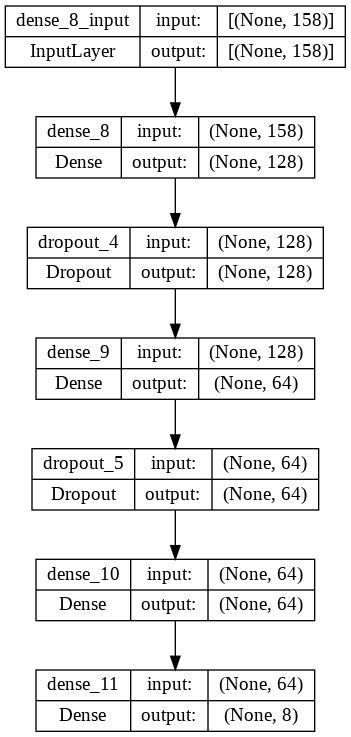

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(m, show_shapes = True, show_layer_names = True)

Set up the fitting and get on with it.

In [64]:
m.compile(loss = 'categorical_crossentropy', 
          optimizer = SGD(learning_rate = 0.01, 
                          decay = 1e-5, 
                          momentum = 0.8, 
                          nesterov = True), 
          metrics = ['categorical_accuracy'])
import numpy as np
f = m.fit(np.array(X), np.array(Y), epochs = 20, batch_size = 10, verbose = 1) # just a little for a quick demo

Epoch 1/30
120/120 [==============================] - 1s 8ms/step - loss: 1.9467 - categorical_accuracy: 0.2317
Epoch 2/30
120/120 [==============================] - 1s 8ms/step - loss: 1.6968 - categorical_accuracy: 0.3983
Epoch 3/30
120/120 [==============================] - 1s 8ms/step - loss: 1.2376 - categorical_accuracy: 0.6250
Epoch 4/30
120/120 [==============================] - 1s 8ms/step - loss: 0.7328 - categorical_accuracy: 0.8042
Epoch 5/30
120/120 [==============================] - 1s 9ms/step - loss: 0.4288 - categorical_accuracy: 0.8917
Epoch 6/30
120/120 [==============================] - 1s 8ms/step - loss: 0.2649 - categorical_accuracy: 0.9375
Epoch 7/30
120/120 [==============================] - 1s 8ms/step - loss: 0.1833 - categorical_accuracy: 0.9575
Epoch 8/30
120/120 [==============================] - 1s 8ms/step - loss: 0.1448 - categorical_accuracy: 0.9608
Epoch 9/30
120/120 [==============================] - 1s 9ms/step - loss: 0.1241 - categorical_accuracy:

Now, how do we use this model to generate bot responses? We need to figure out the tag for whatever the user writes and then pick a response based on that.

In [68]:
userinput = input('Write here to what you want the bot to respond: ')

Write here to what you want the bot to respond: hello who am i talking to


In [69]:
uw = set([ l.lemmatize(w) for w in nltk.word_tokenize(userinput) ])
BoW = [ 1 * (w in uw) for w in words ]
print(len(BoW))
threshold = 0.3 # discard unpromising results
import tensorflow as tf
datapoint = tf.convert_to_tensor(np.array([BoW]))
p = m.predict(datapoint)[0] # predict just this one data point
print(classes) # reminder
for outcome, label in zip(p, classes):
  if outcome > threshold: # could be a match
    print(outcome, label)

158
1/1 [==============================] - 0s 16ms/step
['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
0.9993849 Intro


If there is a clear winner, we can just use that.

In [52]:
best = np.argmax(p) # use the highest as our match
chosen = classes[best] # the class to use to respond
print(f'Chose class {chosen}')
from random import choice # we pick one at random
for i in intents['intents']:
  if i['tag'] == chosen: 
    print(choice(i['responses']))
    break

Chose class Olympus
Link: Olympus wiki


You can go run the cell above that takes a user input to try again.